# Introduction

Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts. This is usually used on social media posts and customer reviews in order to automatically understand if some users are positive or negative and why. The goal of this study is to show how sentiment analysis can be performed using python. Here are some of the main libraries we will use:

- NLTK: the most famous python module for NLP techniques
- Gensim: a topic-modelling and vector space modelling toolkit
- Scikit-learn: the most used python machine learning library

We will use here some hotel reviews data. Each observation consists in one customer review for one hotel. Each customer review is composed of a textual feedback of the customer's experience at the hotel and an overall rating. The data can be found here:
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

For each textual review, we want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 2.5/10 to 10/10. In order to simplify the problem we will split those into two categories:
- bad reviews have overall ratings < 5
- good reviews have overall ratings >= 5

The challenge here is to be able to predict this information using only the raw textual data from the review.
Let's get it started!


In [1]:
!git clone https://github.com/mahmoudfazeli/Perpetua.git

Cloning into 'Perpetua'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 6), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (20/20), 3.25 MiB | 2.88 MiB/s, done.


# Load data

We first start by loading the raw data. Each textual reviews is splitted into a positive part and a negative part. We group them together in order to start with only raw text data and no other information.

In [2]:
import pandas as pd
data = pd.read_csv('./Perpetua/datasets/hotel_reviews.csv')
#reviews = pd.read_csv('hotel_reviews - Copy.csv')
#y = reviews.reviews_rating
#X = reviews.drop('reviews_rating', axis = 1, inplace = False)
#reviews = reviews.dropna(axis=0, subset=['reviews_text'])
#reviews = reviews.dropna(axis=0, subset=['reviews_title'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  object 
 1   dateadded             10000 non-null  object 
 2   dateupdated           10000 non-null  object 
 3   address               10000 non-null  object 
 4   categories            10000 non-null  object 
 5   primarycategories     10000 non-null  object 
 6   city                  10000 non-null  object 
 7   country               10000 non-null  object 
 8   keys                  10000 non-null  object 
 9   latitude              10000 non-null  float64
 10  longitude             10000 non-null  float64
 11  name                  10000 non-null  object 
 12  postalcode            10000 non-null  object 
 13  province              10000 non-null  object 
 14  reviews_date          10000 non-null  object 
 15  reviews_dateseen    

In [3]:
data.isnull().sum()

id                         0
dateadded                  0
dateupdated                0
address                    0
categories                 0
primarycategories          0
city                       0
country                    0
keys                       0
latitude                   0
longitude                  0
name                       0
postalcode                 0
province                   0
reviews_date               0
reviews_dateseen           0
reviews_rating             0
reviews_sourceurls         0
reviews_text               1
reviews_title              1
reviews_usercity        5836
reviews_userprovince    7295
reviews_username           0
sourceurls                 0
websites                   0
location                   0
dtype: int64

In [4]:
data = data.dropna(axis=0, subset=['reviews_text'])
data = data.dropna(axis=0, subset=['reviews_title'])

In [5]:
data.shape

(9998, 26)

In [6]:
data.head()

,id,dateadded,dateupdated,address,categories,primarycategories,city,country,keys,latitude,...,reviews_rating,reviews_sourceurls,reviews_text,reviews_title,reviews_usercity,reviews_userprovince,reviews_username,sourceurls,websites,location
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)


In [7]:



# append the positive and negative text reviews
#reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
data["is_bad_review"] = data["reviews_rating"].apply(lambda x: 1 if x < 4 else 0)
# select only relevant columns
reviews = data[["reviews_text", "is_bad_review"]]
reviews.head()

,reviews_text,is_bad_review
0,Our experience at Rancho Valencia was absolute...,0
1,Amazing place. Everyone was extremely warm and...,0
2,We booked a 3 night stay at Rancho Valencia to...,0
3,Currently in bed writing this for the past hr ...,1
4,I live in Md and the Aloft is my Home away fro...,0


In [8]:
reviews.isnull().sum()

reviews_text     0
is_bad_review    0
dtype: int64

In [9]:
#check the type 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews_text   9998 non-null   object
 1   is_bad_review  9998 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 234.3+ KB


In [10]:
reviews.reviews_text=reviews.reviews_text.astype(str)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
#reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

Reviews data is sampled in order to speed up computations.

# Clean data

In [12]:
# remove 'No Negative' or 'No Positive' from text
#df_reviews["reviews_text"] = df_reviews["reviews_text"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

The next step consists in cleaning the text data with various operations:

In [13]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [14]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews["review_clean"] = reviews["reviews_text"].apply(lambda x: clean_text(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
reviews.head()

,reviews_text,is_bad_review,review_clean
0,Our experience at Rancho Valencia was absolute...,0,experience rancho valencia absolutely perfect ...
1,Amazing place. Everyone was extremely warm and...,0,amazing place everyone extremely warm welcomin...
2,We booked a 3 night stay at Rancho Valencia to...,0,book night stay rancho valencia play tennis si...
3,Currently in bed writing this for the past hr ...,1,currently bed write past hr dog bark squeal ca...
4,I live in Md and the Aloft is my Home away fro...,0,live md aloft home away home...we stayed night...


To clean textual data, we call our custom 'clean_text' function that performs several transformations:
- lower the text
- tokenize the text (split the text into words) and remove the punctuation
- remove useless words that contain numbers
- remove useless stop words like 'the', 'a' ,'this' etc.
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

Now that we have cleaned our data, we can do some feature engineering for our modelization part.

# Feature engineering

In [16]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["reviews_text"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
reviews.head()

,reviews_text,is_bad_review,review_clean,neg,neu,pos,compound
0,Our experience at Rancho Valencia was absolute...,0,experience rancho valencia absolutely perfect ...,0.0,0.669,0.331,0.9162
1,Amazing place. Everyone was extremely warm and...,0,amazing place everyone extremely warm welcomin...,0.0,0.654,0.346,0.9650
2,We booked a 3 night stay at Rancho Valencia to...,0,book night stay rancho valencia play tennis si...,0.0,0.727,0.273,0.9748
3,Currently in bed writing this for the past hr ...,1,currently bed write past hr dog bark squeal ca...,0.0,1.000,0.000,0.0000
4,I live in Md and the Aloft is my Home away fro...,0,live md aloft home away home...we stayed night...,0.0,0.838,0.162,0.8713


We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [18]:
# add number of characters column
reviews["nb_chars"] = reviews["reviews_text"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["reviews_text"].apply(lambda x: len(x.split(" ")))

reviews.head()

,reviews_text,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
0,Our experience at Rancho Valencia was absolute...,0,experience rancho valencia absolutely perfect ...,0.0,0.669,0.331,0.9162,169,29
1,Amazing place. Everyone was extremely warm and...,0,amazing place everyone extremely warm welcomin...,0.0,0.654,0.346,0.9650,283,52
2,We booked a 3 night stay at Rancho Valencia to...,0,book night stay rancho valencia play tennis si...,0.0,0.727,0.273,0.9748,471,81
3,Currently in bed writing this for the past hr ...,1,currently bed write past hr dog bark squeal ca...,0.0,1.000,0.000,0.0000,198,37
4,I live in Md and the Aloft is my Home away fro...,0,live md aloft home away home...we stayed night...,0.0,0.838,0.162,0.8713,307,58


Next, we add some simple metrics for every text:
- number of characters in the text
- number of words in the text

In [19]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews = pd.concat([reviews, doc2vec_df], axis=1)

In [20]:
reviews.head()

,reviews_text,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,Our experience at Rancho Valencia was absolute...,0,experience rancho valencia absolutely perfect ...,0.0,0.669,0.331,0.9162,169,29,-0.005281,-0.364853,0.192835,-0.214701,-0.064165
1,Amazing place. Everyone was extremely warm and...,0,amazing place everyone extremely warm welcomin...,0.0,0.654,0.346,0.9650,283,52,0.063424,-0.125081,0.197462,-0.258637,-0.251291
2,We booked a 3 night stay at Rancho Valencia to...,0,book night stay rancho valencia play tennis si...,0.0,0.727,0.273,0.9748,471,81,0.296176,0.430764,0.553954,-0.563485,-0.432367
3,Currently in bed writing this for the past hr ...,1,currently bed write past hr dog bark squeal ca...,0.0,1.000,0.000,0.0000,198,37,0.396732,0.032271,0.059145,-0.141958,-0.139376
4,I live in Md and the Aloft is my Home away fro...,0,live md aloft home away home...we stayed night...,0.0,0.838,0.162,0.8713,307,58,0.286701,-0.124483,0.238912,-0.511139,-0.340605


The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [21]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document. 

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:
- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [22]:
reviews.head()

,reviews_text,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yes,word_yet,word_yogurt,word_yolanda,word_york,word_you,word_young,word_yummy,word_zero,word_zoo
0,Our experience at Rancho Valencia was absolute...,0,experience rancho valencia absolutely perfect ...,0.0,0.669,0.331,0.9162,169,29,-0.005281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amazing place. Everyone was extremely warm and...,0,amazing place everyone extremely warm welcomin...,0.0,0.654,0.346,0.9650,283,52,0.063424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,We booked a 3 night stay at Rancho Valencia to...,0,book night stay rancho valencia play tennis si...,0.0,0.727,0.273,0.9748,471,81,0.296176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Currently in bed writing this for the past hr ...,1,currently bed write past hr dog bark squeal ca...,0.0,1.000,0.000,0.0000,198,37,0.396732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,I live in Md and the Aloft is my Home away fro...,0,live md aloft home away home...we stayed night...,0.0,0.838,0.162,0.8713,307,58,0.286701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
reviews.shape

(9998, 2446)

# Exploratory data analysis


In order to have a better understanding of our data, let's explore it a little:

In [24]:
# show is_bad_review distribution
reviews["is_bad_review"].value_counts(normalize = True)

0    0.728546
1    0.271454
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

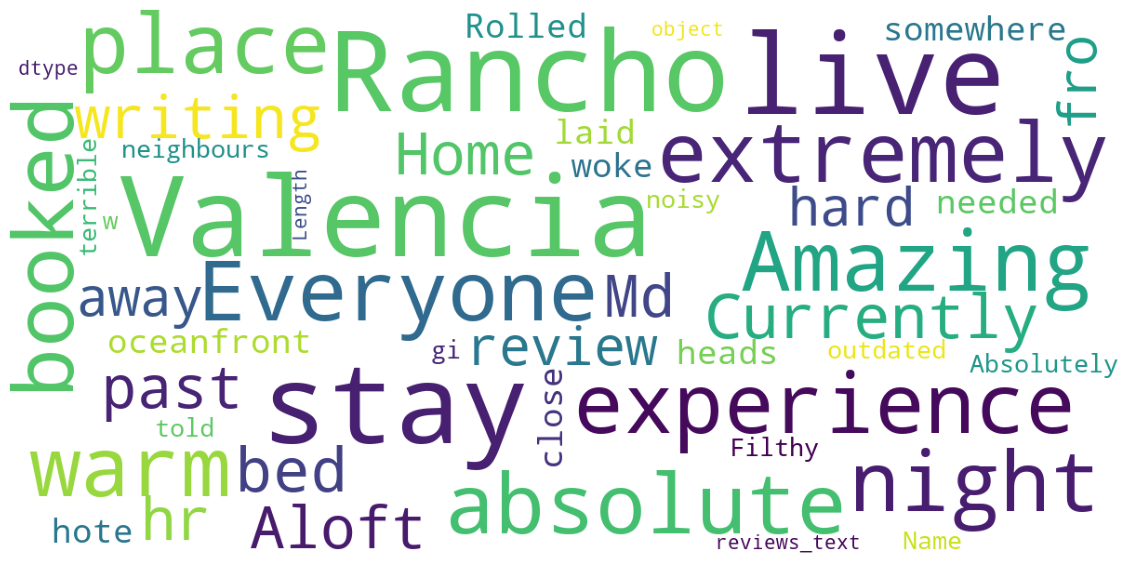

In [25]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews["reviews_text"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [26]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews_text", "pos"]].head(10)

,reviews_text,pos
554,Good: Great value. Great location.,0.931
4150,"Good: Great value, excellent customer service",0.868
896,Good: Great value! Very friendly staff. Excell...,0.851
3565,"Great experience. Friendly, helpful staff.",0.835
7251,"Great, friendly, helpful staff. Nice bar/resta...",0.835
870,"Good: Great staff, superb rooms, brilliant loc...",0.832
703,Good: great location Good services,0.832
680,"Good: Great location,comfortable beds,very clean",0.829
1028,"Good: Good location, comfortable bed",0.820
837,"Good: Perfect Location, friendly staff, amazin...",0.819


The most positive reviews indeed correspond to some good feedbacks.

In [27]:
# lowest negative sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("neg", ascending = False)[["reviews_text", "neg"]].head(10)

,reviews_text,neg
4156,Bad: Ac wasnt working . Good: Clean,0.731
3631,Bad: The eggs was nasty.,0.703
815,Bad: The elevators were a problem.,0.674
3822,Bad: Nothing. Good: Beautiful and romantic,0.658
4199,Bad: No microwave at breakfast.,0.655
1427,"Bad: Possibly lower parking rates,.",0.655
1871,I hate it very disappointed. It is a dump I wo...,0.641
675,Bad: Room was terribly dirty. Good: Location,0.629
3618,Bad: key didn't work. Good: helpfulness of staff,0.624
803,Bad: HODO lounge service was poor.,0.623


Some errors can be found among the most negative reviews: Vader sometimes interpret 'no' or 'nothing' as negative words whereas they are sometimes used to say that there were no problems with the hotel. Fortunately, most of the reviews are indeed bad ones.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


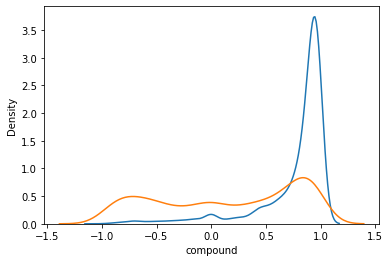

In [28]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews[reviews['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.

This shows us that previously computed sentiment features will be very important in our modelling part.

# Modelling reviewer_score

In [29]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "reviews_text", "review_clean"]
features = [c for c in reviews.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews[features], reviews[label], test_size = 0.20, random_state = 42)

We first choose which features we want to use to train our model. Then we split our data into two parts:
- one to train our model
- one to assess its performances

We will next use a Random Forest (RF) classifier for our predictions.

In [30]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.069718
2,pos,0.061259
0,neg,0.039968
6,doc2vec_vector_0,0.038108
1,neu,0.024506
9,doc2vec_vector_3,0.012874
188,word_bad,0.012690
959,word_great,0.011023
7,doc2vec_vector_1,0.010517
4,nb_chars,0.010305


The most important features are indeed the ones that come from the previous sentiment analysis. The vector representations of the texts also have a lot of importance in our training. Some words appear to have a fairly good importance as well.

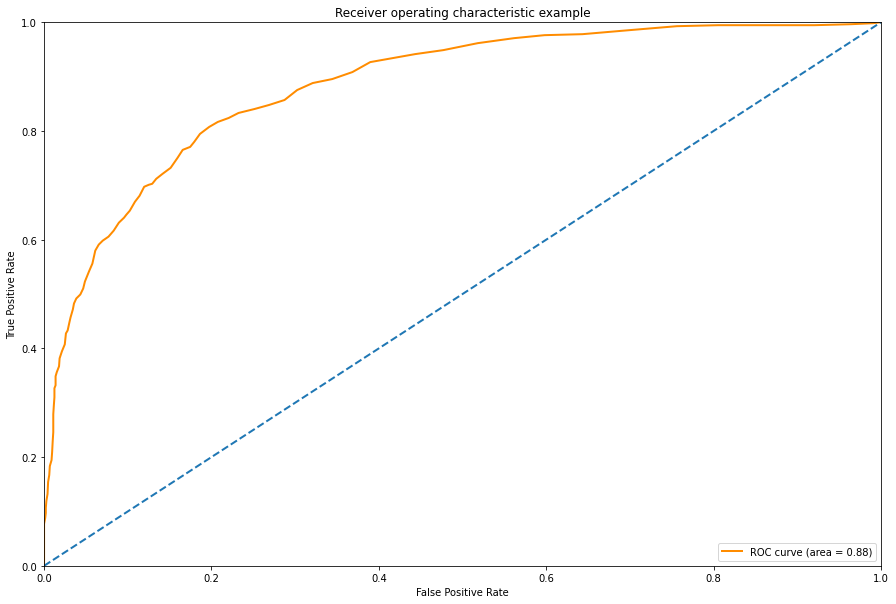

In [31]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.

Why? First let us remind the False Positive Rate formula, which corresponds to the x axis of the ROC curve: FPR (False Positive Rate) = # False Positives / # Negatives.

Here the # Negatives corresponds to our number of good reviews which is very high because our dataset is imbalanced. This means that even with some False Positives, our FPR will tend to stay very low. Our model will be able to make a lot of false positives predictions and still have a low false positive rate, while increasing the true positive rate and therefore artificially increasing the AUC ROC metric.

In [32]:
!pip install funcsigs

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

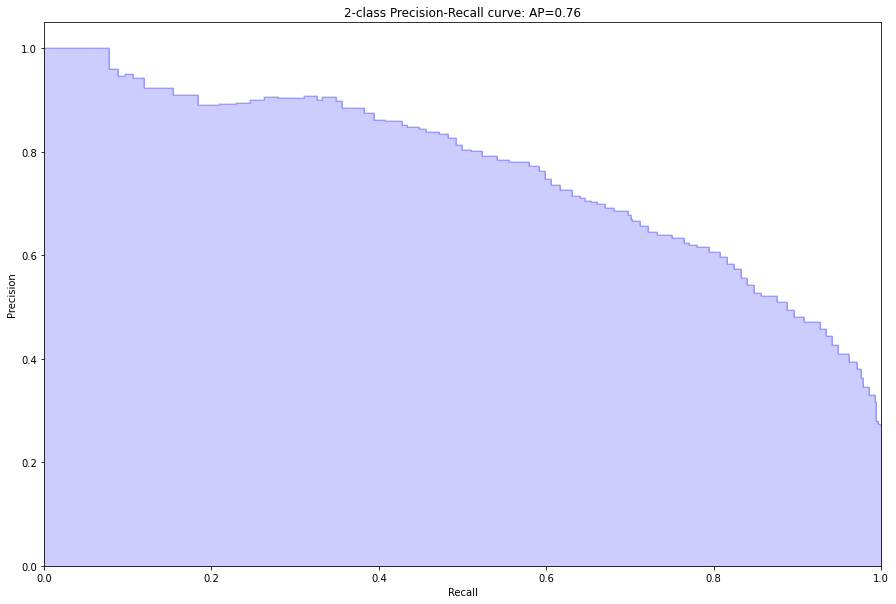

In [33]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
#from sklearn.utils.fixes import signature
from funcsigs import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

A better metric in this imbalanced situation is the AUC PR (Area Under the Curve Precision Recall), or also called AP (Average Precision). 

We can see that the precision decreases when we increase the recall. This shows us that we have to choose a prediction thresold adapted to our needs. If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. On the contrary, if we want to be really confident about our predictions but don't mind about not finding all the positive observations, we should set a high thresold that will get us a high precision and a low recall.

In order to know if our model performs better than another classifier, we can simply use the AP metric. To assess the quality of our model, we can compare it to a simple decision baseline. Let's take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.

Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.35, which is more than 8 times higher than the AP of the random method. This means that our model has a good predictive power.

# Conclusion

It is completely possible to use only raw text as input for making predictions. The most important thing is to be able to extract the relevant features from this raw source of data. This kind of data can often come as a good complementary source in data science projects in order to extract more learning features and increase the predictive power of the models.